# Making ocean maps with NASA satellite data

In [10]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.image as mpimg
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage, TextArea)
from matplotlib.gridspec import GridSpec

import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.gridspec import GridSpec

# References

For netCDF (.nc) data file generation:
https://giovanni.gsfc.nasa.gov/giovanniReferences

The below code was modified from this NASA tutorial, which explains how to read netCDF ocean data into Python:
https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20read%20and%20plot%20NetCDF%20MERRA-2%20data%20in%20Python

Cartopy package details:
https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/advanced_plotting.html

# Read in data for each isolation date and name accordingly

In [3]:
#load the net CDF files that were made on the giovanni website
Tempdata_04 = Dataset('g4.timeAvgMap.MODISA_L3m_SST_8d_4km_R2019_0_sst.20210124-20210130.82W_28N_66W_37N.nc', mode='r')
#Tempdata_13 = Dataset('05.22-28.2022.MODISA_L3m_SST_8d_4km_R2019_0_sst.20220522-20220528.82W_28N_66W_37N.nc', mode='r')
#Tempdata_68 = Dataset('09.23-29.2021.g4.timeAvgMap.MODISA_L3m_SST_8d_4km_R2019_0_sst.20210923-20210929.82W_26N_65W_33N.nc', mode='r')


#Chldata= Dataset('05.23-29.2021.MODISA_L3m_CHL_8d_4km_2018_chlor_a.20210523-20210529.82W_28N_66W_37N.nc', mode='r')
#Bathym= Dataset('SAB_bathym_vol2.nc', mode='r')
#load earth relief data
#grid = pygmt.datasets.load_earth_relief(resolution="05m", region=[-77.4207, -81.5735, 32.4447, 30.2914])
bathym = cfeature.NaturalEarthFeature(category='physical', name='bathymetry_K_200', scale='10m')

## Assign the netCDF variable of interest to a python variable for each plot

In [5]:

Tlon_04 = Tempdata_04.variables['lon'][:]
Tlat_04 = Tempdata_04.variables['lat'][:]

Temp_04 = Tempdata_04.variables['MODISA_L3m_SST_8d_4km_R2019_0_sst'][:][:][:]


#Tlon_68 = Tempdata_68.variables['lon'][:]
#Tlat_68 = Tempdata_68.variables['lat'][:]

#Temp_68 = Tempdata_68.variables['MODISA_L3m_SST_8d_4km_R2019_0_sst'][:][:][:]


#Tlon_13 = Tempdata_13.variables['lon'][:]
#Tlat_13 = Tempdata_13.variables['lat'][:]

#Temp_13 = Tempdata_13.variables['MODISA_L3m_SST_8d_4km_R2019_0_sst'][:][:][:]


# Main fig map

### Read in SEM images

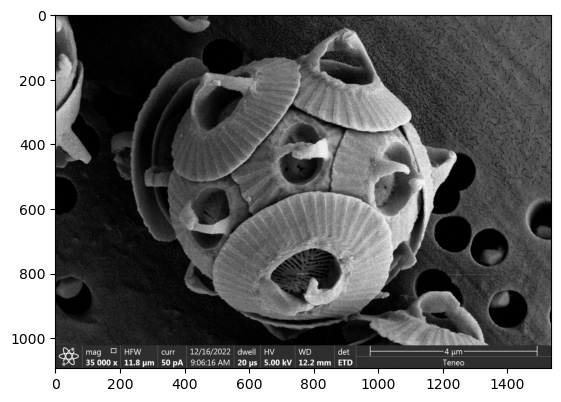

In [7]:
ehux = mpimg.imread('13a_005.tif')
plt.imshow(ehux, cmap='gray')
goce = mpimg.imread('6a_002.tif')
plt.imshow(goce, cmap='gray')

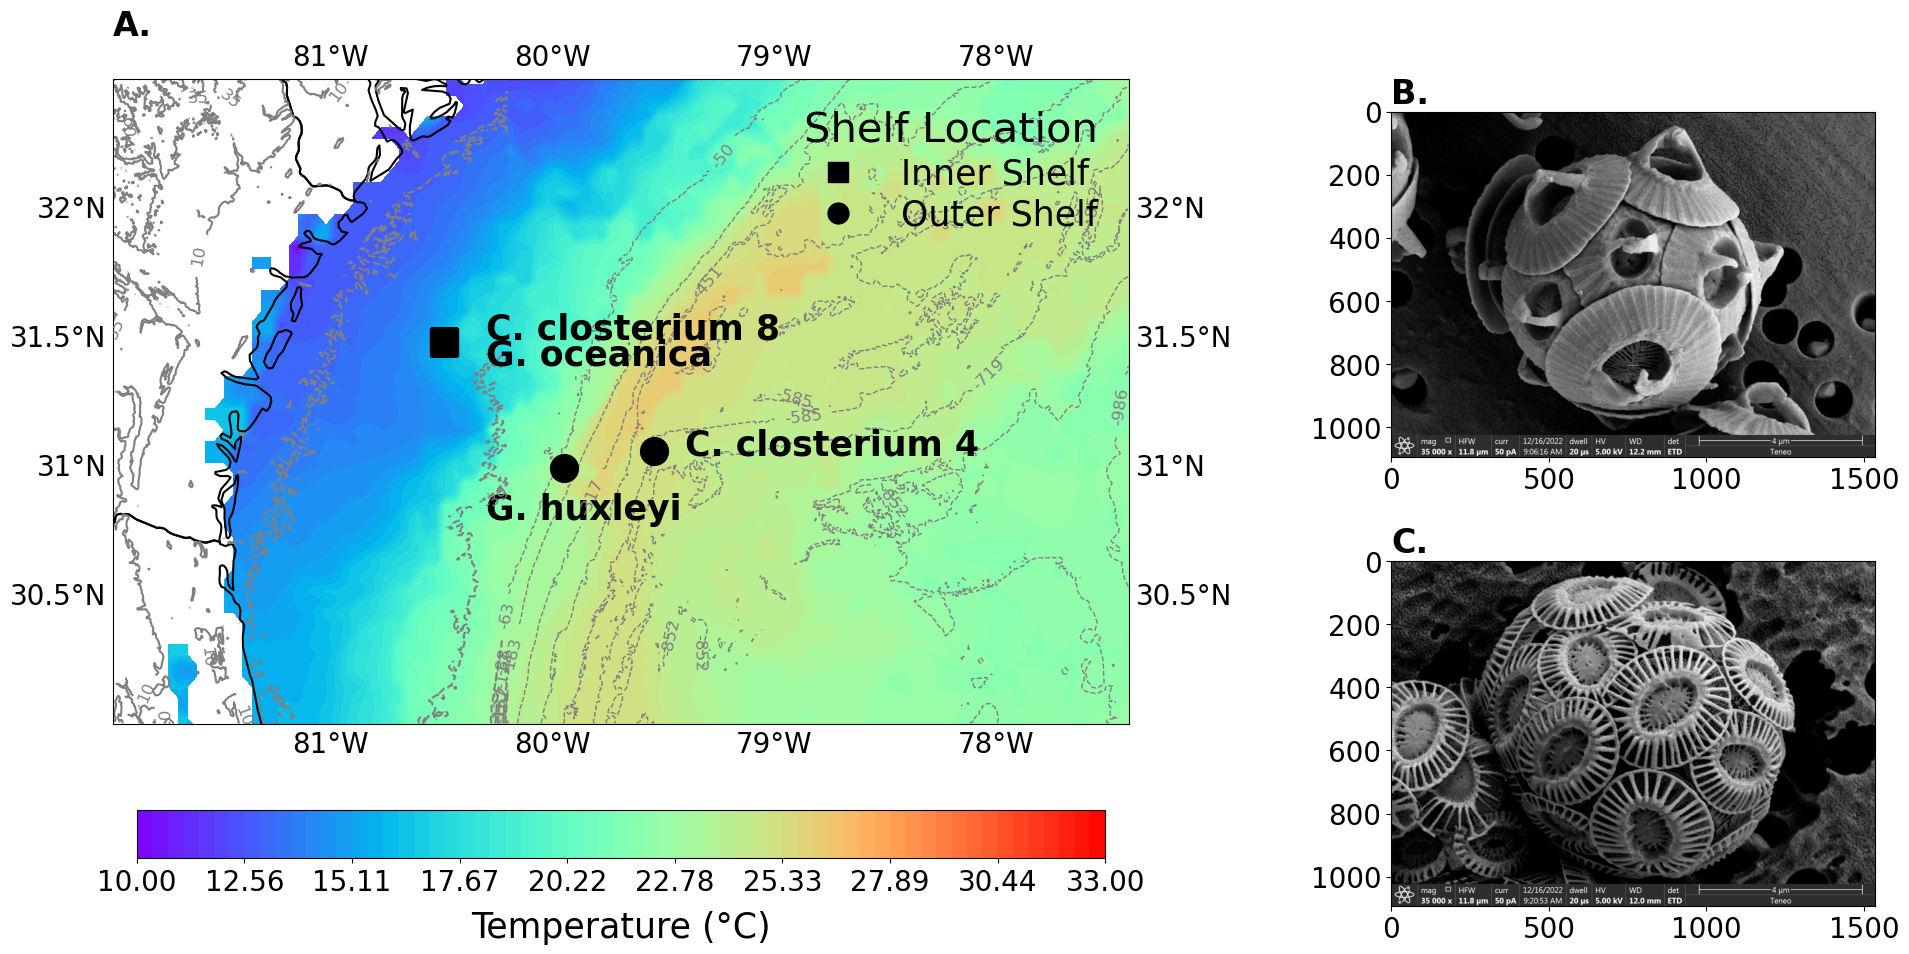

In [61]:
bathymetry = Dataset('ETOPO_2022_v1_15s_N45W090_surface.nc', mode='r')

# Extract longitude, latitude, and elevation
bathy_lon = bathymetry["lon"][:]
bathy_lat = bathymetry["lat"][:]
bathy_elev = bathymetry["z"][:]  # Elevation (negative values for ocean depth)

# Subset bathymetry data to the map extent
lon_min, lon_max = -81.98, -77.4
lat_min, lat_max = 30, 32.5

lon_indices = np.where((bathy_lon >= lon_min) & (bathy_lon <= lon_max))[0]
lat_indices = np.where((bathy_lat >= lat_min) & (bathy_lat <= lat_max))[0]

# Extract the subset of the bathymetry data
bathy_subset_lon = bathy_lon[lon_indices]
bathy_subset_lat = bathy_lat[lat_indices]
bathy_subset_elev = bathy_elev[lat_indices.min():lat_indices.max() + 1, lon_indices.min():lon_indices.max() + 1]


# Set the figure size, projection, and extent
fig = plt.figure(figsize=(20,10), tight_layout=True)
gs=GridSpec(nrows=2,ncols=2, width_ratios=[5,2])

#make all axis ticks 20 pt font
plt.rc('font', size=20)

ax1 = fig.add_subplot(gs[:,0], projection=ccrs.Mercator())
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,1])

ax1.gridlines(draw_labels=True, color='none')
ax1.set_extent([lon_min, lon_max, lat_min, lat_max])

#Set contour levels, then draw the plot with a colorbar
levels=np.linspace(10,33,64)
cs = ax1.contourf(Tlon_04, Tlat_04, Temp_04, transform=ccrs.PlateCarree(),cmap=plt.cm.rainbow, levels=levels)
cb = plt.colorbar(cs, ax=ax1, orientation="horizontal",pad=0.1,shrink=0.8)
cb.ax.tick_params(labelsize=20)
cb.set_label('Temperature (°C)', size=25, labelpad=10)

#Add state lines
ax1.add_feature(cfeature.STATES, zorder=1, linewidth=1.5)

# Add black contour lines for bathymetry
levels_fine = np.linspace(elev_min, elev_max, 50)  # Fine resolution
levels_coarse = np.linspace(elev_min, elev_max, 10)  # Reduced density beyond 80°W

# Create separate subsets
lon_fine = bathy_subset_lon[bathy_subset_lon <= -80.2]  # Longitudes for fine contours
lon_coarse = bathy_subset_lon[bathy_subset_lon > -80.2]  # Longitudes for coarse contours

# Extract corresponding elevation data
elev_fine = bathy_subset_elev[:, bathy_subset_lon <= -80.2]
elev_coarse = bathy_subset_elev[:, bathy_subset_lon > -80.2]

# Contour for the main region (high resolution)
bathymetry_contours_main = ax1.contour(lon_fine, bathy_subset_lat, elev_fine, 
                                       colors='grey', linewidths=1.5, transform=ccrs.PlateCarree(),
                                       levels=levels_fine)

# Contour for the region beyond 80°W (lower resolution)
bathymetry_contours_coarse = ax1.contour(lon_coarse, bathy_subset_lat, elev_coarse, 
                                         colors='grey', linewidths=1, transform=ccrs.PlateCarree(),
                                         levels=levels_coarse)

# Label contours
ax1.clabel(bathymetry_contours_main, inline=True, fontsize=12, fmt='%1.0f', colors='grey', inline_spacing=10)
ax1.clabel(bathymetry_contours_coarse, inline=True, fontsize=12, fmt='%1.0f', colors='grey', inline_spacing=10)

#add dots where phytoplankton were isolated: 
###January cruise    
ax1.plot(-79.541873, 31.067497, 'black', marker="o", markersize=20, linestyle="None", transform=ccrs.Geodetic(), )

###September cruise
ax1.plot(-80.48775, 31.4864,'black', marker='s',markersize=20, linestyle="None",transform=ccrs.Geodetic(), label="Inner Shelf" )

###March cruise
ax1.plot(-79.94816, 31,'black', marker='o', markersize=20, linestyle="None", transform=ccrs.Geodetic(),label="Outer Shelf")

#add text labes for organisms isolated from each cruise
uga4=ax1.text(-79.4, 31.05, 'C. closterium 4', size=25, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')
uga8=ax1.text(-80.3, 31.5,'C. closterium 8', size=25, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold') 
uga6=ax1.text(-80.3, 31.4,'G. oceanica', size=25, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')      
uga13=ax1.text(-80.3, 30.8,'G. huxleyi', size=25, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')

#add in normal legend  
shelf=ax1.legend(loc="upper right", labelspacing=0.2, markerscale=.75, fontsize=25, frameon=False, title='Shelf Location', title_fontsize=30)
ax1.set_title('A.', size=24, fontweight='bold', loc='left')
#add images of coccolithophores
ax2.imshow(goce, cmap='gray')
ax2.set_title('B.', size=24, fontweight='bold', loc='left')

ax3.imshow(ehux, cmap='gray')
ax3.set_title('C.', size=24, fontweight='bold', loc='left')

plt.show()

fig.savefig('sstMainMap.png', format='png', dpi=800)

In [51]:


print(f"Elevation min: {elev_min}, Elevation max: {elev_max}")

Elevation min: -1120.0, Elevation max: 84.13924407958984


# Combined Temperature Plot for supplimental figs

/var/folders/cw/g7w36k0922v035l7dvppfqg40000gn/T/ipykernel_2174/481574176.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1500x2500 with 4 Axes> than <Figure size 2000x1000 with 4 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(cs, orientation="vertical", pad=0.1,shrink=0.7)


NameError: name 'Tlon_68' is not defined

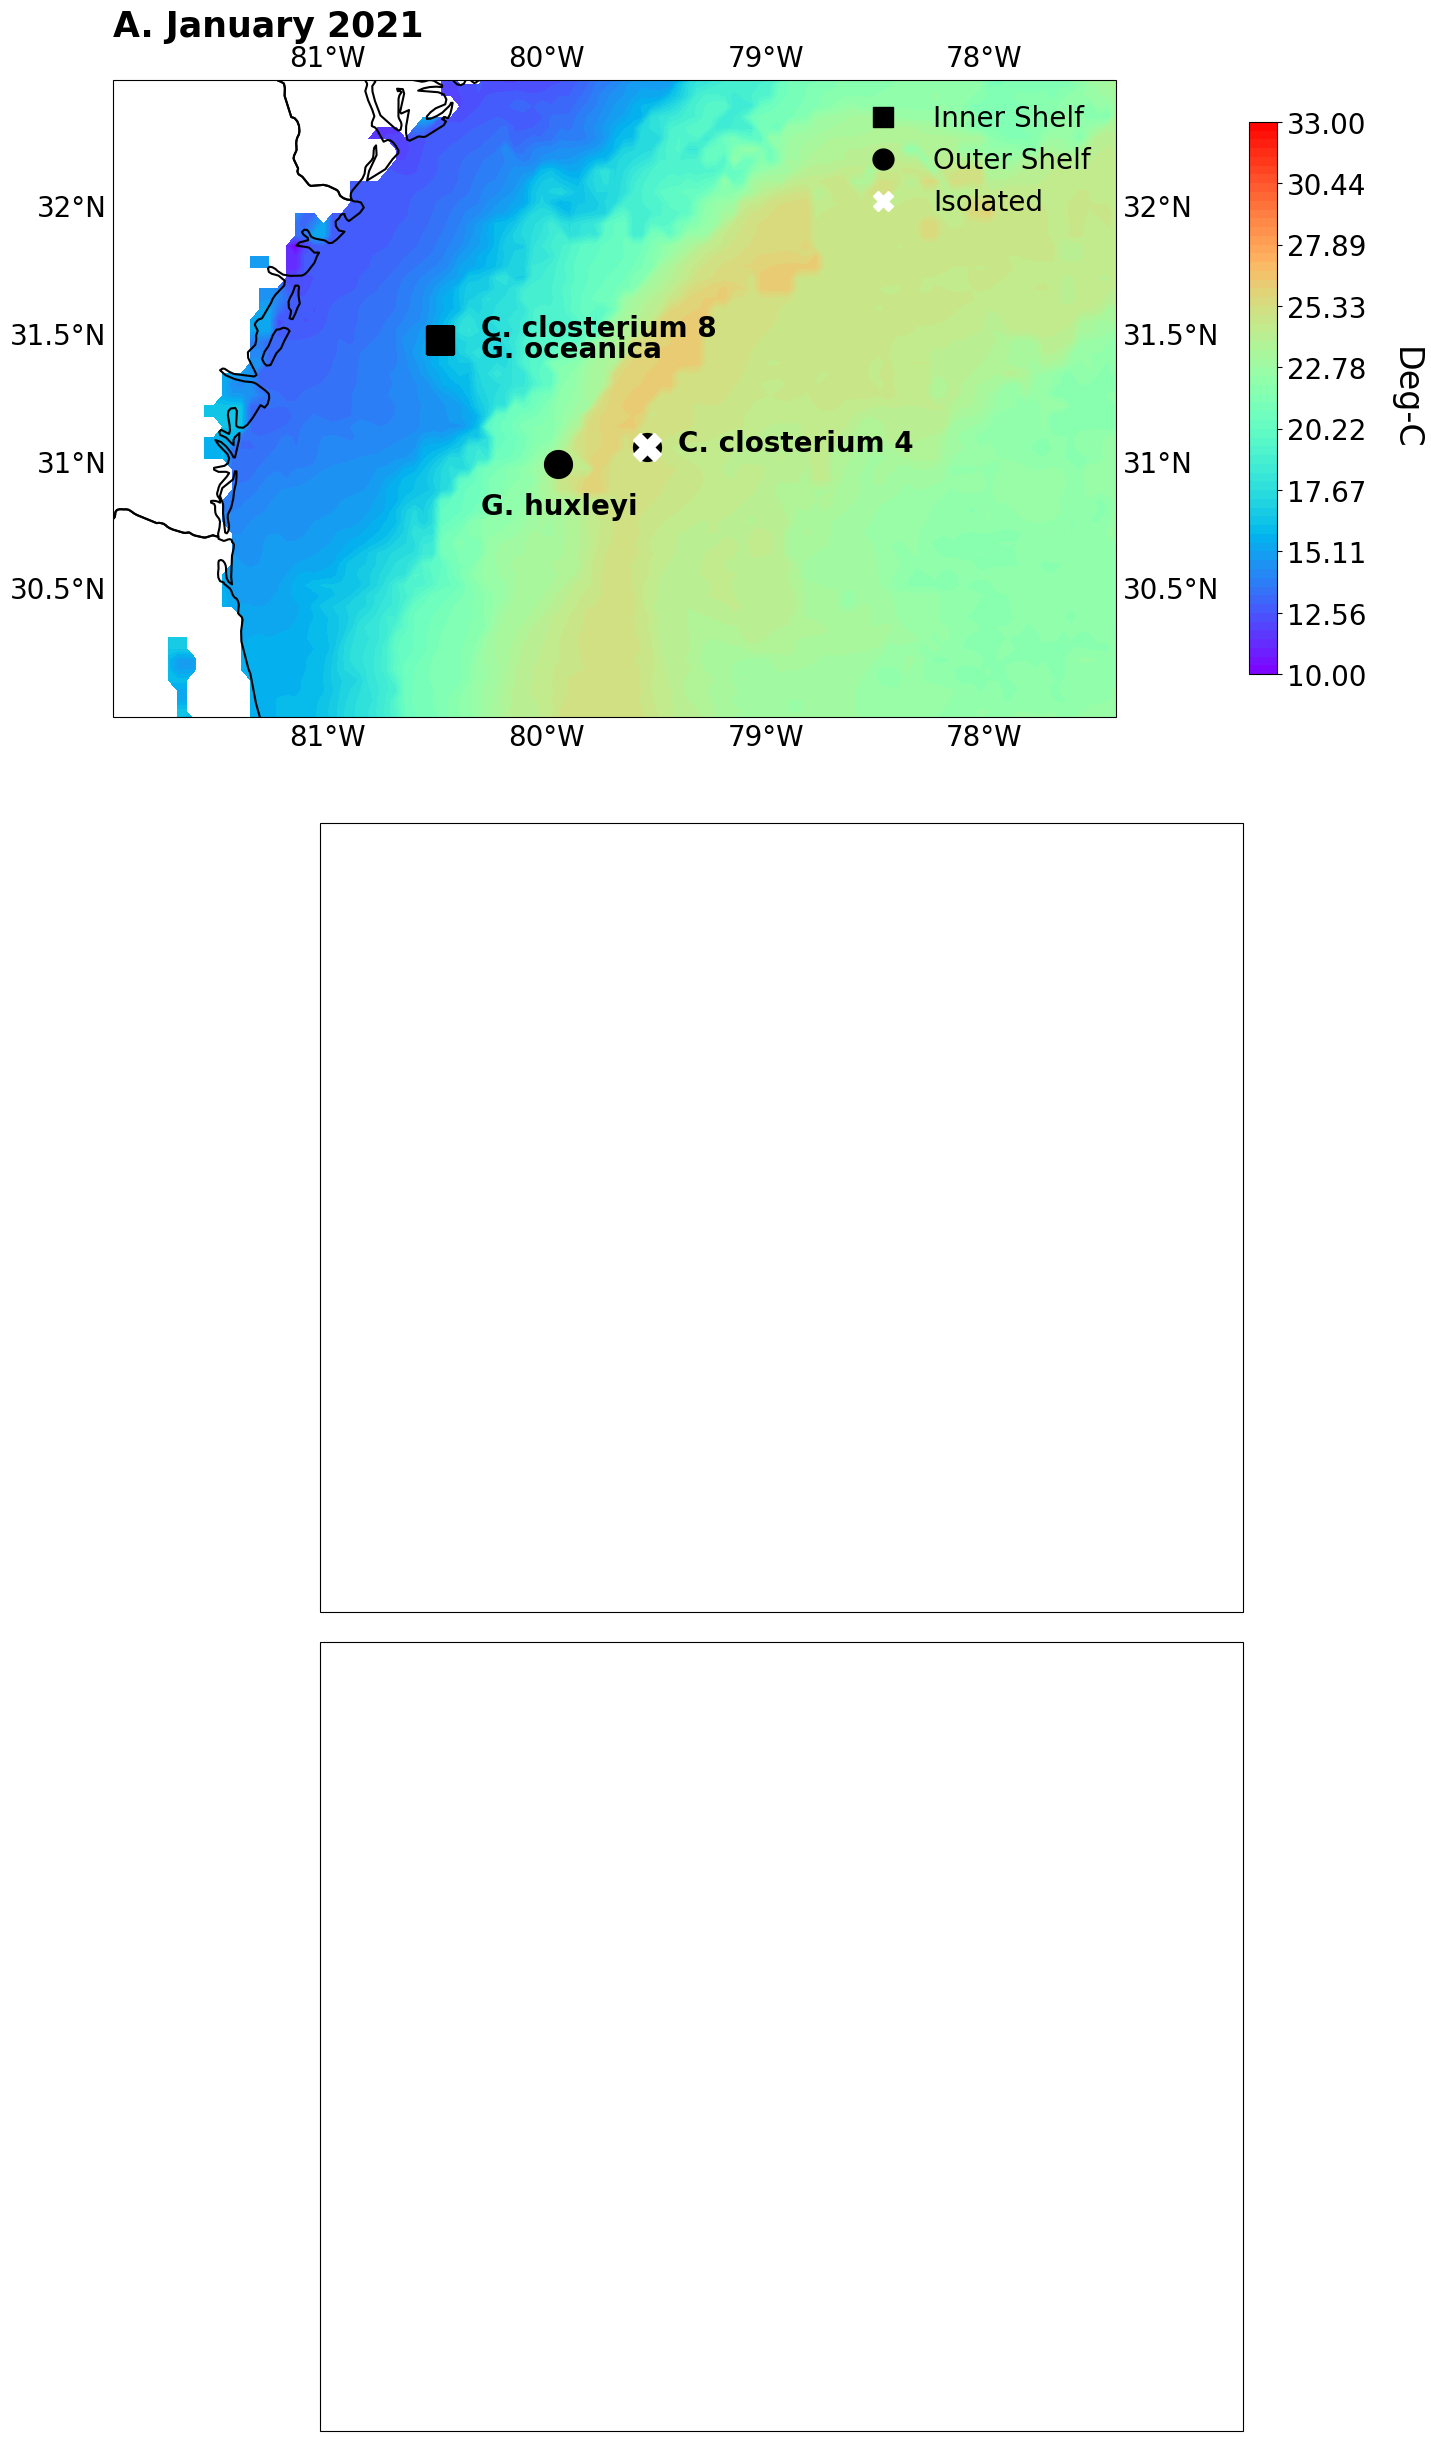

In [48]:

#Temperature Plot function:
def tempPlot(ax, templon, templat, temp, cruise, culture):
# Set the figure projection, and extent
    ax.tick_params(labelsize=20)
    ax.gridlines(draw_labels=True, color='none')
    ax.set_extent([-77.4, -81.98, 30, 32.5])
#add plot title
    ax.set_title(cruise, size=25, fontweight='bold', loc='left')

#Set contour levels, then draw the plot with a colorbar
    levels=np.linspace(10,33,64)
    cs = ax.contourf(templon, templat, temp, transform=ccrs.PlateCarree(),cmap=plt.cm.rainbow, levels=levels)
    cb = fig.colorbar(cs, orientation="vertical", pad=0.1,shrink=0.7)
    cb.ax.tick_params(labelsize=20)
    cb.set_label('Deg-C',size=24,rotation=270,labelpad=40)

#Add state lines
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5)

#add dots where phytoplankton were isolated: 
    ###January cruise    
    ax.plot(-79.541873, 31.067497, 'black', marker="o", markersize=20, linestyle="None", transform=ccrs.Geodetic(), )
    
    ###September cruise
    ax.plot(-80.48775, 31.4864,'black', marker='s',markersize=20, linestyle="None",transform=ccrs.Geodetic(), label="Inner Shelf" )
    
    ###March cruise
    ax.plot(-79.94816, 31,'black', marker='o', markersize=20, linestyle="None", transform=ccrs.Geodetic(),label="Outer Shelf")
    
    #add text labes for organisms isolated from each cruise
    ax.text(-79.4, 31.05, 'C. closterium 4', size=20, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')
    ax.text(-80.3, 31.5,'C. closterium 8', size=20, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold') 
    ax.text(-80.3, 31.42,'G. oceanica', size=20, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')      
    ax.text(-80.3, 30.8,'G. huxleyi', size=20, color='black', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')

    if culture== '04' :
        ax.plot(-79.541873, 31.067497,'white', marker='X', markersize=20, markeredgewidth=1, linestyle="None", transform=ccrs.Geodetic(),label="Isolated")
    if culture=='68':
        ax.plot(-80.48775, 31.4864,'white', marker='X', markersize=20, markeredgewidth=1, linestyle="None", transform=ccrs.Geodetic(),label="Isolated")
    if culture=='13':
        ax.plot(-79.94816, 31,'white', marker='X', markersize=20, markeredgewidth=1, linestyle="None", transform=ccrs.Geodetic(),label="Isolated")
#add 2 legends: shelf location from dot shape, taxa 
###Taxa legend has to be made from hand, plot a line with color and lable for each taxa, but not placed on plot
#    diatom = mlines.Line2D([], [], color='black', label='Diatom')
#    haptophyte = mlines.Line2D([], [],  color='white', label='Haptophyte')
    
    #make the named legend, setting the line width to 0
#    taxa=ax.legend(handles=[diatom, haptophyte], handlelength=0, frameon=False, title='  Taxa', title_fontsize=15, 
#                   loc='lower right', prop={'weight':'bold', 'size':'13'}, alignment='left')
    #set the legend text to color of the lines
#    for line,text in zip(taxa.get_lines(), taxa.get_texts()):
#        text.set_color(line.get_color())
    #draw this legend
#    ax.add_artist(taxa)  

    leg=ax.legend(loc="upper right",  labelspacing=0.5, markerscale=.75, fontsize=20, frameon=False)
   
allMaps=plt.figure(figsize=(15,25), tight_layout=True)
ax0 = plt.subplot(311, projection=ccrs.Mercator())
ax1 = plt.subplot(312, projection=ccrs.Mercator())
ax2 = plt.subplot(313, projection=ccrs.Mercator())
                  
tempPlot(ax0, Tlon_04, Tlat_04, Temp_04, "A. January 2021", "04")
tempPlot(ax1, Tlon_68, Tlat_68, Temp_68, "B. September 2021","68")
tempPlot(ax2, Tlon_13, Tlat_13, Temp_13, "C. May 2022","13")

plt.show()

allMaps.savefig('allTempMaps.png', format='png')

/var/folders/hb/9bf22l_54jv8y8k33trtkg900000gr/T/ipykernel_2395/1249342319.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


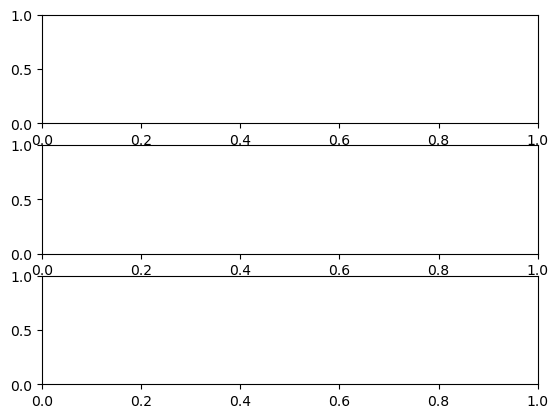

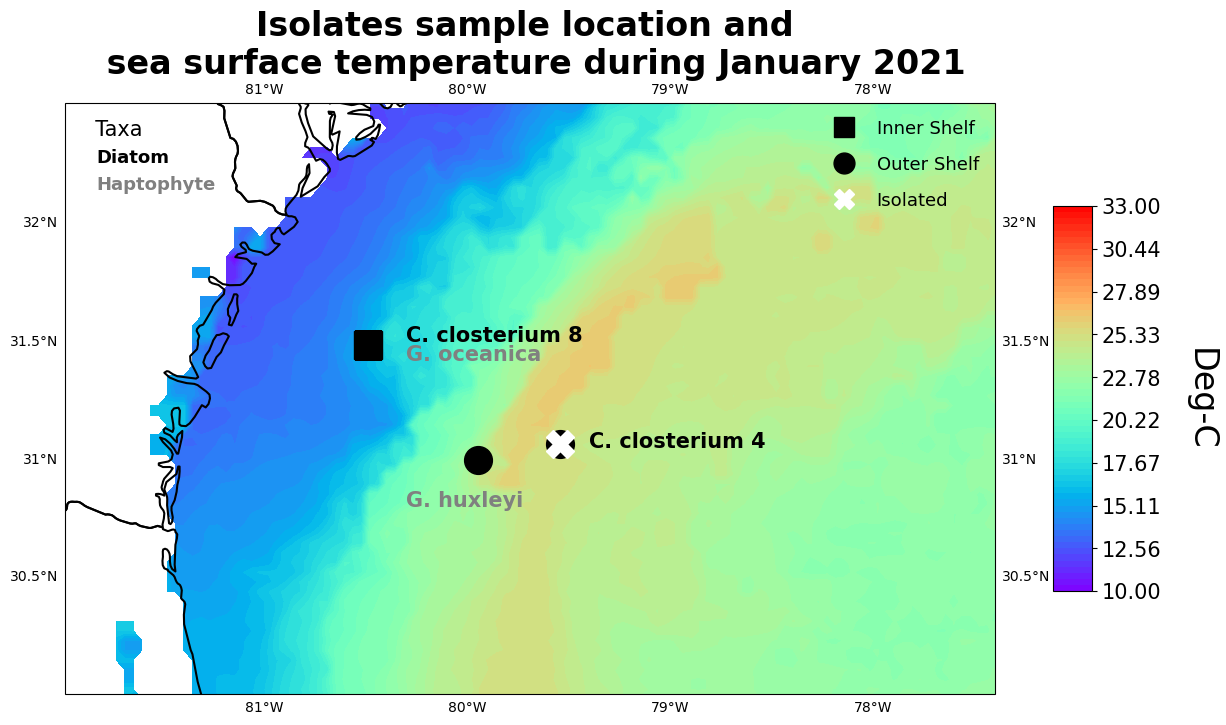

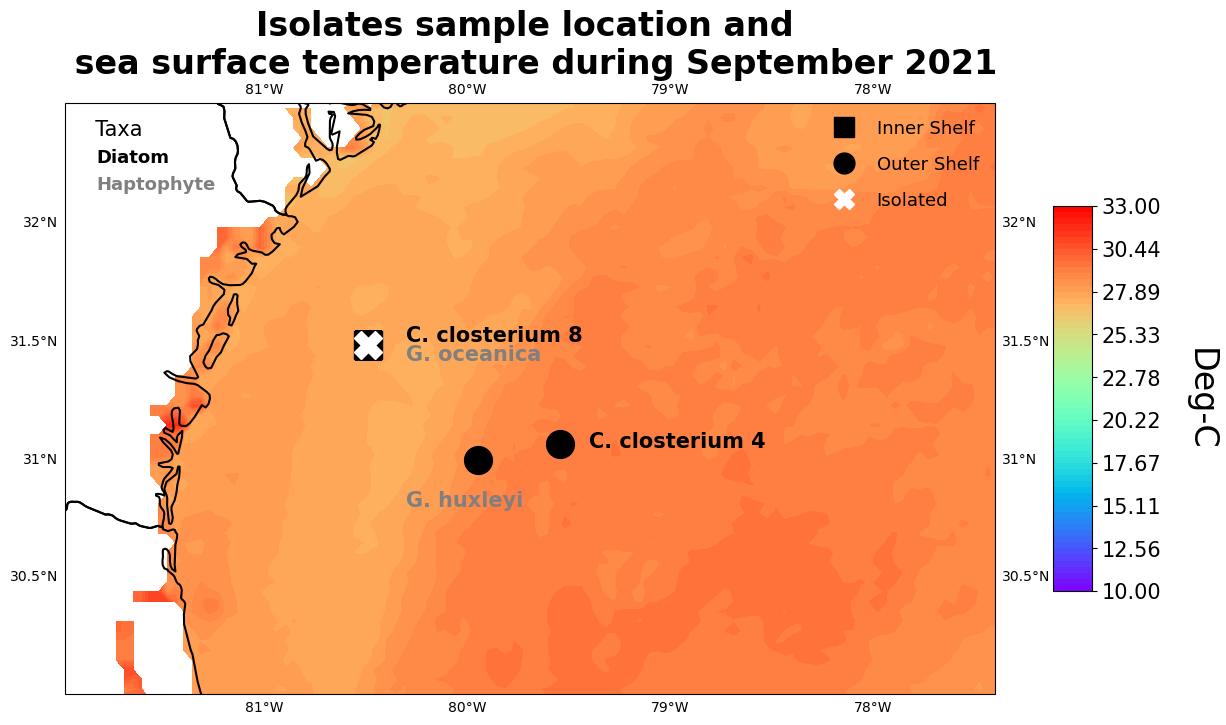

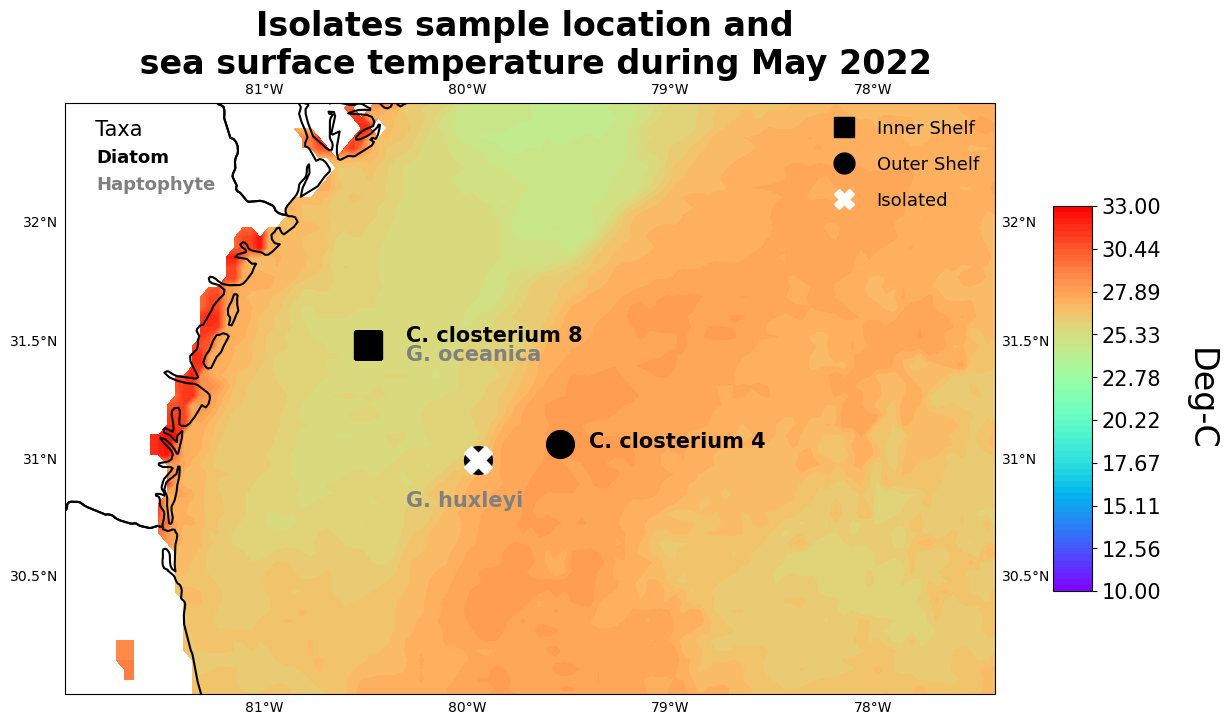

In [3]:
#Chlorophyll plot:

# Modified from: https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20read%20and%20plot%20NetCDF%20MERRA-2%20data%20in%20Python


# Set the figure size, projection, and extent
fig = plt.figure(figsize=(10,15))

ax = plt.axes(projection=ccrs.Mercator())

ax.set_extent([-77.4207, -81.5735, 30.2914, 32.4447])

ax.gridlines(draw_labels=True, linestyle='--',color='silver')


#Add plot title and state lines
t = "2021 May"

plt.title('MODISA Chloraphyll a {}'.format(t), size=14, fontweight='bold')

ax.add_feature(cfeature.STATES, zorder=1, linewidth=1.5)

#Set contour levels, then draw the plot and a colorbar
levels=np.linspace(0,20,20)

plt.contourf(chlalon, chlalat, chla, transform=ccrs.PlateCarree(),cmap=plt.cm.rainbow,levels=levels)

cb = plt.colorbar(ax=ax,orientation="vertical", aspect=12, shrink=0.3, pad=0.1)

cb.set_label('mg m^-3',size=16,rotation=270,labelpad=15)

cb.ax.tick_params(labelsize=10)


#add dots where phytoplankton were isolated
ax.plot(-79.541873, 31.067497, 'white', marker="o", markersize=10, transform=ccrs.Geodetic(), )

ax.text(-79.6, 31.16, 'C. closterium 4', size=12, color='white', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')

ax.plot(-80.48775, 31.4864,'white', marker="o",markersize=10, transform=ccrs.Geodetic(), )

ax.text(-80.8, 31.56,'C. closterium 8 and G. oceanica', size=12, color='white', transform=ccrs.Geodetic(), horizontalalignment='left', fontweight='bold')

ax.plot(-79.94816, 31.01392,'white', marker="o", markersize=10, transform=ccrs.Geodetic(),)

ax.text(-80.35, 31.1,'E. huxleyi', size=12, color="white", transform=ccrs.Geodetic(), horizontalalignment='center', fontweight='bold')

NameError: name 'plt' is not defined

In [177]:
fig.savefig('MODISA_Chla_isolations_{}.png'.format(t), format='png', dpi=360)